<a href="https://colab.research.google.com/github/rjnakano/manejo-inventarios-pdg/blob/main/Notebooks/EDADOC052321.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade kmodes

Requirement already up-to-date: kmodes in /usr/local/lib/python3.7/dist-packages (0.11.0)


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# !pip install --upgrade kmodes

# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes

from sklearn.preprocessing import StandardScaler

# Import module for data visualization
from plotnine import *
import plotnine

# Preparación para el análisis exploratorio de los datos


*   Cargue de los datos
*   Elemento de lista



Configuración del las fuentes almacenadas en el repositorio de Github

In [3]:
sourcepath = 'https://raw.githubusercontent.com/rjnakano/manejo-inventarios-pdg/main/Datos/Raw'
destpath = 'https://raw.githubusercontent.com/rjnakano/manejo-inventarios-pdg/main/Datos/Transformed'

## Cargue de los datos RAW del inventario
Los datos a tratar, corresponden a todos aquellos productos activos que han presentado correcciones durante los inventarios cíclicos y que están ubicados en la bodega principal de la empresa empezando desde enero de 2018

| Field | Description |
| :- | :-- |
| TDATE | Fecha en la que se realizó la corrección al inventario |
| SKU | Identificador del item |
| LOC | Ubicación del item en la bodega compuesta por tres dimensiones (pasillo, columna y estantería) |
| QTY | Corrección (cantidad), donde las menores a 0 representan las unidades faltantes mientras que las mayores a 0 la unidades adicionales no contabilizadas |
| AISLE | Número del pasillo de la ubicación del item |
| COLUMN | Columna en del pasillo en la que se encuentra el item |
| SHELF | Número de la estantería en la que se encuentra el item |
| TYPE | Tipo de ubicación |
| IG | Agrupación a la que pertenece el item |
| IPG | Agrupación de precio a la que pertence el item |
| HTS | Clasificación fiscal (Gobierno - U.S. International Trade Commission) del item |
| CLASS | Flag para identificar si se mantiene inventario de un item (1) o no (0) |
| PLANNING | Flag para identificar si un item se planea (1) o no (0) |
| ABC | Clasificación ABC de inventario |
| UOM | Tipo de unidad de medida del item |
| CREATION | Fecha de creación del item en el sistema |
| CAT | Categoría de agrupación del item |
| COSTX | Costo extendido de la transacción, costo x cantidad |
| QTYBEFORE | Número de unidades antes de la corrección |
| QTYVAR | Porcentaje de variación (QTY/QTYBEFORE) |
| WEIGHT | Peso del item |
| LENGTH | Largo del item |
| HEIGHT | Altura del item |
| WIDTH | Ancho del item |
| CONTRPERC | Porcentaje de contribución del item (ABC)|


In [4]:
filename = 'LOCTRANSCX.CSV'
df = pd.read_csv(f"{sourcepath}/{filename}")

In [5]:
pd.set_option('max_columns', df.shape[1])
df.head(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
0,20180210,SKU3921,17Q3,-1.0,17.0,Q,3,LOC4,IG56,NaN,HTS119,1,1,B,PC,20161028,CAT17,-289.8802,38.0,-2.63,0.0,0.0,0.0,0.0,0.01
1,20180210,SKU3922,17Q2,1.0,17.0,Q,2,LOC4,IG56,NaN,HTS119,1,1,B,PC,20161028,CAT17,289.5527,4.0,25.00,0.0,0.0,0.0,0.0,0.00
2,20180210,SKU3923,17W2,4.0,17.0,W,2,LOC4,IG56,NaN,HTS119,1,1,C,PC,20161028,CAT17,1111.3121,8.0,50.00,0.0,0.0,0.0,0.0,0.00
3,20180210,SKU3924,17B2,-1.0,17.0,B,2,LOC4,IG56,NaN,HTS119,1,1,B,PC,20161028,CAT17,-266.8633,11.0,-9.09,0.0,0.0,0.0,0.0,0.00
4,20180210,SKU3926,15P7,-2.0,15.0,P,7,LOC4,IG56,NaN,HTS119,1,1,C,PC,20161028,CAT17,-517.0436,18.0,-11.11,0.0,0.0,0.0,0.0,0.00


In [6]:
df.tail(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
17002,20201213,SKU8964,23C10,1.0,23.0,C,10,LOC5,IG5,IPG1604,HTS67,1,0,C,BX,20000930,CAT2,316.3834,0.0,100.00,45.0,162.0,2.375,6.00,0.0
17003,20201213,SKU8971,21I2,2.0,21.0,I,2,LOC4,IG5,IPG1604,HTS67,1,0,C,BX,20001001,CAT2,626.9100,0.0,100.00,45.0,162.0,2.375,6.00,0.0
17004,20201213,SKU8972,22F8,15.0,22.0,F,8,LOC4,IG5,IPG1604,HTS67,1,0,C,BX,20000930,CAT2,4959.6974,11.0,136.36,45.0,162.0,2.375,6.00,0.0
17005,20201213,SKU8972,24I4,-4.0,24.0,I,4,LOC4,IG5,IPG1604,HTS67,1,0,C,BX,20000930,CAT2,-1322.5860,4.0,-100.00,45.0,162.0,2.375,6.00,0.0
17006,20201213,SKU8979,20G1,-1.0,20.0,G,1,LOC4,IG5,IPG1880,HTS67,1,0,C,BX,20050603,CAT2,-255.2001,2.0,-50.00,39.0,162.0,2.250,4.75,0.0


In [7]:
df.shape

(17007, 25)

## Eliminación de duplicados
Debido al proceso de generación de los datos, en el cual se toma la información de dos fuentes diferentes, cabe la posibilidad de la generación de duplicados los cuales deberán ser manejados.


*   Identificación de registros duplicados 
*   Validación de registros
*   Eliminación de los registros extras
*   Verificación del proceso



In [8]:
df[df.duplicated()==True]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
10286,20201213,SKU10071,07G7,1.0,7.0,G,7,LOC4,IG8,IPG1453,HTS15,1,1,A,BX,20150813,CAT3,2094.1441,0.0,100.0,33.00,13.0,8.5,13.0,0.10
10288,20201213,SKU10071,10K2,1.0,10.0,K,2,LOC4,IG8,IPG1453,HTS15,1,1,A,BX,20150813,CAT3,2094.1441,0.0,100.0,33.00,13.0,8.5,13.0,0.10
10355,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10358,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10469,20201213,SKU10347,15G2,2.0,15.0,G,2,LOC4,IG57,NaN,HTS151,1,0,A,BX,20180924,CAT17,433.5837,0.0,100.0,2.00,4.0,3.0,16.0,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16899,20201213,SKU1759,11G2,1.0,11.0,G,2,LOC4,IG64,NaN,HTS15,1,1,A,BX,20131101,CAT14,700.3199,0.0,100.0,22.00,16.0,14.0,12.0,0.09
16901,20201213,SKU1760,11U3,1.0,11.0,U,3,LOC4,IG64,NaN,HTS15,1,1,A,BX,20131101,CAT14,791.6199,0.0,100.0,22.00,16.0,14.0,12.0,0.02
16903,20201213,SKU1760,37I3,1.0,37.0,I,3,LOC4,IG64,NaN,HTS15,1,1,A,BX,20131101,CAT14,791.6199,0.0,100.0,22.00,16.0,14.0,12.0,0.02
16954,20201213,SKU6156,21G9,1.0,21.0,G,9,LOC4,IG7,IPG1815,HTS95,1,1,A,BX,20160721,CAT8,1023.6613,0.0,100.0,60.00,192.0,3.0,7.0,0.04


In [9]:
df[(df.SKU == 'SKU10231') & (df.TDATE == 20201213)]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
10354,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10355,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10356,20201213,SKU10231,17R6,-3710.0,17.0,R,6,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,-2865.7695,3710.0,-100.0,0.01,0.5,0.5,0.5,0.05
10357,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10358,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05


In [10]:
df.drop_duplicates(keep='first', inplace=True)
df[(df.SKU == 'SKU10231') & (df.TDATE == 20201213)]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
10354,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10356,20201213,SKU10231,17R6,-3710.0,17.0,R,6,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,-2865.7695,3710.0,-100.0,0.01,0.5,0.5,0.5,0.05
10357,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05


In [11]:
df.shape

(16333, 25)

## Corrección de formatos y nombres de campos

### Cambio de tipos

Es necesario modificar ciertas columnas para que se comporten de acuerdo a las definiciones del negocio

| **Field** | **From** | **To** |
| :-: | :-: | :-: |
| TDATE | Entero | Fecha |
| CREATION | Entero | Fecha |
| CLASS | Entero | Cadena |
| AISLE | Real | Cadena |
| PLANNING | Real | Cadena |
| SHELF | Real | Cadena |


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16333 entries, 0 to 17006
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TDATE      16333 non-null  int64  
 1   SKU        16333 non-null  object 
 2   LOC        16333 non-null  object 
 3   QTY        16333 non-null  float64
 4   AISLE      16261 non-null  float64
 5   COLUMN     16261 non-null  object 
 6   SHELF      16333 non-null  int64  
 7   TYPE       16261 non-null  object 
 8   IG         16333 non-null  object 
 9   IPG        8225 non-null   object 
 10  HTS        16323 non-null  object 
 11  CLASS      16333 non-null  int64  
 12  PLANNING   16333 non-null  int64  
 13  ABC        16333 non-null  object 
 14  UOM        16333 non-null  object 
 15  CREATION   16333 non-null  int64  
 16  CAT        16333 non-null  object 
 17  COSTX      16333 non-null  float64
 18  QTYBEFORE  16333 non-null  float64
 19  QTYVAR     16333 non-null  float64
 20  WEIGHT

In [13]:
df.TDATE = pd.to_datetime(df.TDATE, format='%Y%m%d') 
df.CREATION = pd.to_datetime(df.CREATION, format='%Y%m%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16333 entries, 0 to 17006
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   TDATE      16333 non-null  datetime64[ns]
 1   SKU        16333 non-null  object        
 2   LOC        16333 non-null  object        
 3   QTY        16333 non-null  float64       
 4   AISLE      16261 non-null  float64       
 5   COLUMN     16261 non-null  object        
 6   SHELF      16333 non-null  int64         
 7   TYPE       16261 non-null  object        
 8   IG         16333 non-null  object        
 9   IPG        8225 non-null   object        
 10  HTS        16323 non-null  object        
 11  CLASS      16333 non-null  int64         
 12  PLANNING   16333 non-null  int64         
 13  ABC        16333 non-null  object        
 14  UOM        16333 non-null  object        
 15  CREATION   16333 non-null  datetime64[ns]
 16  CAT        16333 non-null  object       

In [14]:
df.CLASS=df.CLASS.astype(str)
df['AISLE'].fillna(0, inplace = True) 
#df[df['AISLE'].notna()].AISLE=df[df['AISLE'].notna()].AISLE.astype(int)

In [15]:
df['AISLE']=df['AISLE'].astype(int)
df['AISLE']=df['AISLE'].astype(str)

In [16]:
df.TDATE.head()

0   2018-02-10
1   2018-02-10
2   2018-02-10
3   2018-02-10
4   2018-02-10
Name: TDATE, dtype: datetime64[ns]

In [17]:
df.PLANNING = df.PLANNING.astype(str)
df.SHELF = df.SHELF.astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16333 entries, 0 to 17006
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   TDATE      16333 non-null  datetime64[ns]
 1   SKU        16333 non-null  object        
 2   LOC        16333 non-null  object        
 3   QTY        16333 non-null  float64       
 4   AISLE      16333 non-null  object        
 5   COLUMN     16261 non-null  object        
 6   SHELF      16333 non-null  object        
 7   TYPE       16261 non-null  object        
 8   IG         16333 non-null  object        
 9   IPG        8225 non-null   object        
 10  HTS        16323 non-null  object        
 11  CLASS      16333 non-null  object        
 12  PLANNING   16333 non-null  object        
 13  ABC        16333 non-null  object        
 14  UOM        16333 non-null  object        
 15  CREATION   16333 non-null  datetime64[ns]
 16  CAT        16333 non-null  object       

### Renombramiento
| **Original Name** | **New Name** |
| :-: | :-: |
| WEIGHT | PESO |
| LENGTH | LARGO |
| HEIGHT | ALTO |
| WIDTH | ANCHO |

In [18]:
df = df.rename(columns={"WEIGHT":"PESO","LENGTH":"LARGO","HEIGHT":"ALTO","WIDTH":"ANCHO" })

## Manejo de registros con nulos
* Eliminación de las columnas **IPG** por su gran cantidad de valores vacios y **CREATION** ya que define la fecha de creación en el sistema del producto en su tabla maestra.
* Eliminación de registros con todos los valores nulos
* Crearemos dos data frames:
    * df_na_free: eliminará los registros nulos. 
    * df_imp: Reemplazará los valores NA con valores del negocio.

In [19]:
# Borramos las columnas irrelevantes
df = df.drop(['CREATION','IPG'], axis=1)

In [20]:
# Borramos cualquier fila con todos los valores nulos
df.dropna(axis=0,how="all", inplace=True)

In [21]:
# Finding the null values.
print(df.isnull().sum())

TDATE         0
SKU           0
LOC           0
QTY           0
AISLE         0
COLUMN       72
SHELF         0
TYPE         72
IG            0
HTS          10
CLASS         0
PLANNING      0
ABC           0
UOM           0
CAT           0
COSTX         0
QTYBEFORE     0
QTYVAR        0
PESO          0
LARGO         0
ALTO          0
ANCHO         0
CONTRPERC     0
dtype: int64


### Imputación de valores nulos
De acuerdo a las definiciones del negocio, es válido imputar las ubicaciones de los items que tienen valores nulos, con un sólo valor que les permita reconocerlo en el sistema, aunque no esté ubicado claramente dentro de la bodega.

In [22]:
df.loc[pd.isnull(df['TYPE']), 'TYPE'] = 'AREA' 
df.loc[pd.isnull(df['AISLE']), 'AISLE'] = df['LOC']
df.loc[pd.isnull(df['COLUMN']), 'COLUMN'] = ''
df['HTS'].fillna("No HTS", inplace = True) 
print(df.isnull().sum())
print(df.shape)

TDATE        0
SKU          0
LOC          0
QTY          0
AISLE        0
COLUMN       0
SHELF        0
TYPE         0
IG           0
HTS          0
CLASS        0
PLANNING     0
ABC          0
UOM          0
CAT          0
COSTX        0
QTYBEFORE    0
QTYVAR       0
PESO         0
LARGO        0
ALTO         0
ANCHO        0
CONTRPERC    0
dtype: int64
(16333, 23)


In [23]:
df.shape

(16333, 23)

In [24]:
df = df[((df['QTYVAR']>=0) & (df['COSTX']>=0)) | ((df['QTYVAR']<=0) & (df['COSTX']<=0))]

In [25]:
df.shape

(16328, 23)

# Análisis exploratorio de datos

## Variables Cuantitativas

In [26]:
df.describe()

,QTY,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
count,16328.000000,1.632800e+04,16328.000000,16328.000000,16328.000000,16328.000000,16328.000000,16328.000000,16328.000000
mean,-23.217740,-6.579131e+01,545.023963,51.380509,13.657235,54.020916,4.842357,5.713843,0.089165
std,1271.309519,1.332565e+04,4520.480346,1045.843425,43.088379,64.992341,4.701082,4.383013,0.420466
min,-80500.000000,-2.298156e+05,0.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.000000,-7.362681e+02,2.000000,-50.090000,0.460000,6.000000,1.500000,2.500000,0.000000
50%,-1.000000,-3.336505e+01,18.000000,-1.190000,2.037000,12.000000,3.500000,5.500000,0.010000
75%,4.000000,6.167050e+02,114.000000,48.040000,10.000000,102.000000,7.250000,8.000000,0.030000
max,74000.000000,1.374824e+06,322475.000000,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000


## Variables Categóricas

### Análisis Univariado

In [27]:
df['AISLE'].unique()

array(['17', '15', '18', '19', '22', '2', '23', '16', '13', '12', '14',
       '99', '3', '0', '24', '20', '26', '21', '25', '11', '27', '28',
       '34', '4', '6', '5', '35', '9', '29', '32', '33', '37', '8', '7',
       '30', '31', '10', '1', '40', '38', '39', '41', '88', '43'],
      dtype=object)

In [28]:
df.select_dtypes('object').nunique()

SKU         5295
LOC         4367
AISLE         44
COLUMN        34
SHELF         24
TYPE           4
IG            65
HTS          134
CLASS          2
PLANNING       5
ABC            3
UOM           14
CAT           16
dtype: int64

In [29]:
df['PLANNING'].value_counts()

1    13481
0     2832
4        9
2        4
9        2
Name: PLANNING, dtype: int64

In [30]:
df=df[df['PLANNING']!='9']

In [31]:
# Regla del negocio (diferentes tipos de planeacion)
df.loc[(df['PLANNING']!='0') & (df['PLANNING']!='1'),'PLANNING']='1'

In [32]:
df['PLANNING'].value_counts()

1    13494
0     2832
Name: PLANNING, dtype: int64

In [33]:
df['ABC'].value_counts()

A    7134
C    5733
B    3459
Name: ABC, dtype: int64

In [34]:
df['CLASS'].value_counts()

1    15097
2     1229
Name: CLASS, dtype: int64

In [35]:
df['PLANNING'].value_counts(normalize=True)

1    0.826534
0    0.173466
Name: PLANNING, dtype: float64

In [36]:
df['CAT'].value_counts(normalize=True)*100

CAT17    24.427294
CAT12    15.760137
CAT16    15.104741
CAT8     13.677570
CAT14    13.230430
CAT7      7.558496
CAT3      3.234105
CAT10     1.549675
CAT5      1.231165
CAT2      1.163788
CAT9      0.980032
CAT1      0.888154
CAT4      0.637021
CAT15     0.508392
CAT6      0.042876
CAT11     0.006125
Name: CAT, dtype: float64

### Análisis Multivariado

In [37]:
contingency = pd.crosstab(df['CLASS'], df['PLANNING']) 
contingency 

PLANNING,0,1
CLASS,,
1,1603,13494
2,1229,0


In [38]:
contingency_pct= pd.crosstab(df['CLASS'], df['PLANNING'],normalize='index') 

In [39]:
contingency_pct

PLANNING,0,1
CLASS,,
1,0.10618,0.89382
2,1.00000,0.00000


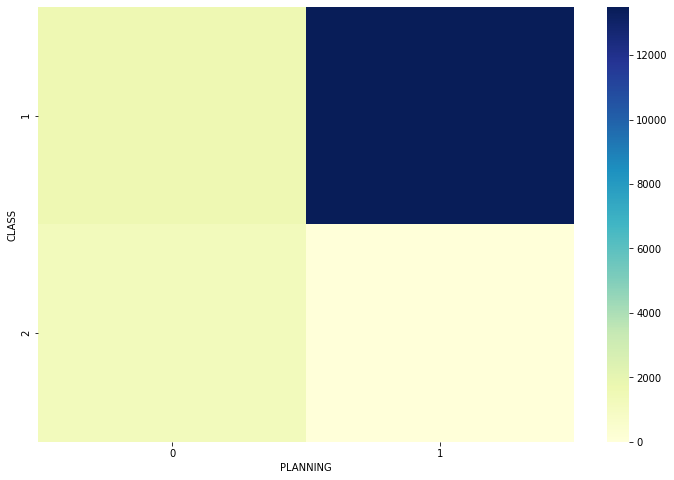

In [40]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contingency, annot=False, cmap="YlGnBu")

In [41]:
contingency = pd.crosstab(df['ABC'], df['PLANNING']) 
contingency 

PLANNING,0,1
ABC,,
A,287,6847
B,404,3055
C,2141,3592


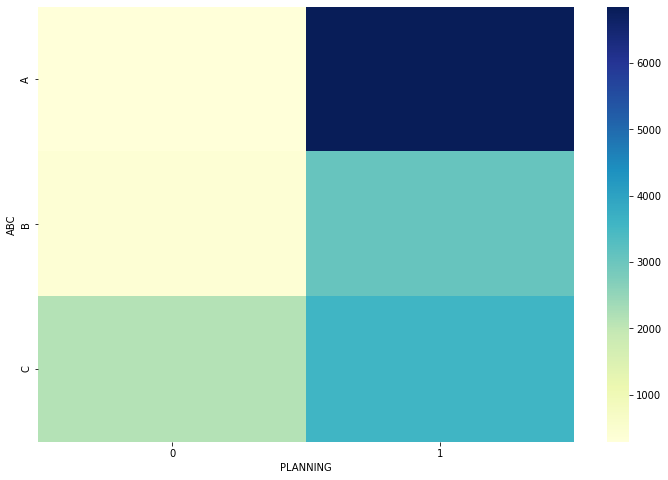

In [42]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contingency, annot=False, cmap="YlGnBu")

In [43]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingency) 
# Print the p-value
print(p)
# Now, p < 0.05 is the usual test for dependence. In this case p is lower than 0.05, so we believe the variables are dependent

0.0


In [44]:
contingency = pd.crosstab(df['CAT'], df['UOM']) 
contingency 

UOM,BDL,BG,BX,EA,FT,PC,PK,PR,RL,SET,SKID,SQFT,TB,YD
CAT,,,,,,,,,,,,,,
CAT1,0,0,145,0,0,0,0,0,0,0,0,0,0,0
CAT10,3,5,234,3,0,0,0,0,8,0,0,0,0,0
CAT11,0,0,1,0,0,0,0,0,0,0,0,0,0,0
CAT12,10,83,472,1,0,6,0,0,51,0,0,0,0,1950
CAT14,11,33,2067,25,0,22,1,0,0,1,0,0,0,0
CAT15,0,53,10,0,0,0,13,0,7,0,0,0,0,0
CAT16,0,84,212,0,279,1678,0,200,1,0,0,0,0,12
CAT17,0,228,333,0,0,2225,0,1155,2,0,0,0,45,0
CAT2,4,23,158,3,0,0,0,0,2,0,0,0,0,0


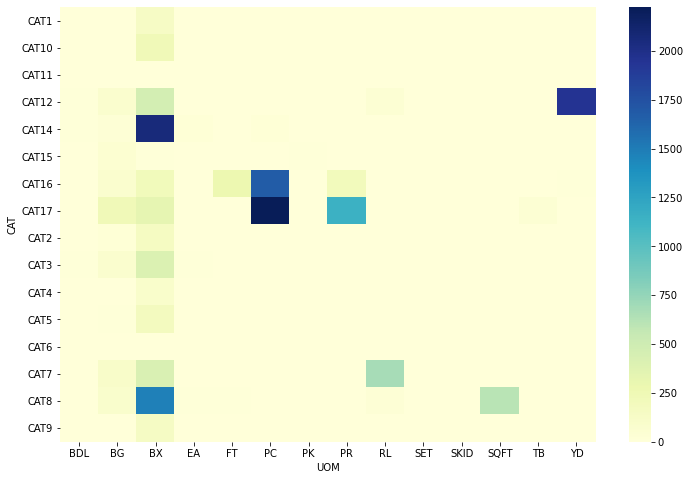

In [45]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contingency, annot=False, cmap="YlGnBu")

In [46]:
contingency = pd.crosstab(df['IG'], df['CAT']) 

In [47]:
contingency

CAT,CAT1,CAT10,CAT11,CAT12,CAT14,CAT15,CAT16,CAT17,CAT2,CAT3,CAT4,CAT5,CAT6,CAT7,CAT8,CAT9
IG,,,,,,,,,,,,,,,,
IG10,0,0,0,0,0,0,0,0,0,0,104,0,0,0,0,0
IG11,0,0,0,0,0,0,0,0,0,0,0,201,0,0,0,0
IG12,0,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0
IG13,0,0,0,0,0,0,0,0,0,344,0,0,0,0,0,0
IG14,0,0,0,0,0,0,0,0,0,0,0,0,0,22,1043,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IG7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,299,0
IG70,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0
IG71,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0


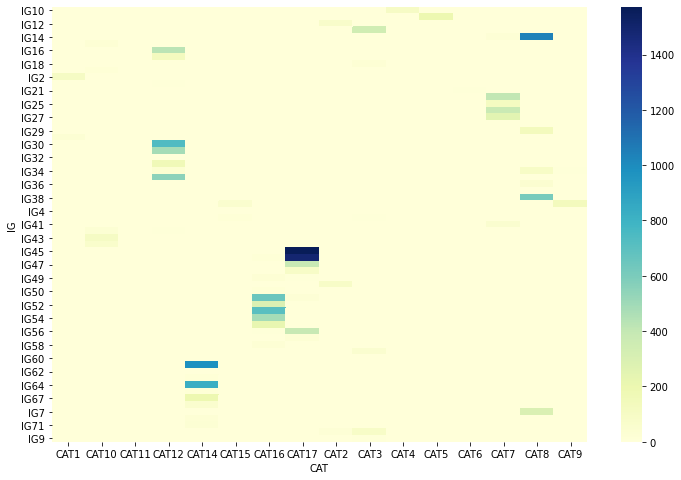

In [48]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contingency, annot=False, cmap="YlGnBu")

In [49]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingency) 
# Print the p-value
print(p)
# Now, p < 0.05 is the usual test for dependence. In this case p is lower than 0.05, so we believe the variables are dependent

0.0


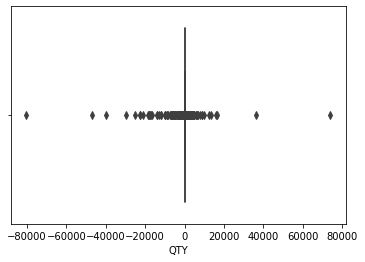

In [50]:
sns.boxplot(x=df['QTY'])

In [51]:
z = np.abs(stats.zscore(df.QTY))
#z = stats.zscore(df.QTY)
df['Zqty']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.01746372 0.01903685 0.02139655 ... 0.03004879 0.01510402 0.01746372]


In [52]:
df.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty
14904,2020-12-13,SKU6374,13C2,-11.0,13,C,2,LOC4,IG45,HTS24,1,1,C,PR,CAT17,-130.0646,41.0,-26.83,0.5,8.5,2.25,6.500,0.00,0.009598
9651,2020-02-14,SKU1511,11P1,1.0,11,P,1,LOC4,IG64,HTS15,1,1,A,BX,CAT14,965.0745,5.0,20.00,34.0,12.0,24.00,12.000,0.02,0.019037
2252,2018-07-03,SKU1796,37K7,2.0,37,K,7,LOC4,IG64,HTS15,1,1,A,BX,CAT14,1203.9478,35.0,5.71,33.0,12.0,20.50,12.000,1.04,0.019823
7655,2019-07-01,SKU6200,99SHAUNA,-1.0,0,,0,AREA,IG14,HTS15,1,1,A,BX,CAT8,-168.3152,1.0,-100.00,1.0,6.0,6.00,4.375,0.01,0.017464
15431,2020-12-13,SKU7568,21J6,1.0,21,J,6,LOC4,IG5,HTS67,2,0,C,BX,CAT2,281.0031,0.0,100.00,40.0,192.0,4.00,8.000,0.00,0.019037


In [53]:
df['QTY'].describe()

count    16326.000000
mean       -23.202454
std       1271.386556
min     -80500.000000
25%         -6.000000
50%         -1.000000
75%          4.000000
max      74000.000000
Name: QTY, dtype: float64

In [54]:
df['Zqty'].describe()

count    16326.000000
mean         0.100920
std          0.994925
min          0.000159
25%          0.016677
50%          0.019037
75%          0.026903
max         63.300388
Name: Zqty, dtype: float64

In [55]:
print('Dentro de 1 desviación estándar:', df.loc[df['Zqty'] < 1,'Zqty'].count(), round(df.loc[df['Zqty'] < 1,'Zqty'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['Zqty'] >= 1) & (df['Zqty'] < 2),'Zqty'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['Zqty'] >= 2) & (df['Zqty'] < 3),'Zqty'].count())
print('Más de de 3 desviación estándar:', df.loc[df['Zqty'] > 3,'Zqty'].count())
print('Más de de 4 desviación estándar:', df.loc[df['Zqty'] > 4,'Zqty'].count())
print('Más de de 10 desviación estándar:', df.loc[df['Zqty'] > 10,'Zqty'].count())
print(df.loc[df['Zqty'] < 1,'Zqty'].count() + df.loc[(df['Zqty'] >= 1) & (df['Zqty'] < 2),'Zqty'].count() + df.loc[(df['Zqty'] >= 2) & (df['Zqty'] < 3),'Zqty'].count() + df.loc[df['Zqty'] > 3,'Zqty'].count())

Dentro de 1 desviación estándar: 16119 98.73 %
Entre 1 y 2 desviaciones estándar: 112
Entre 2 y 3 desviaciones estándar: 27
Más de de 3 desviación estándar: 68
Más de de 4 desviación estándar: 52
Más de de 10 desviación estándar: 22
16326


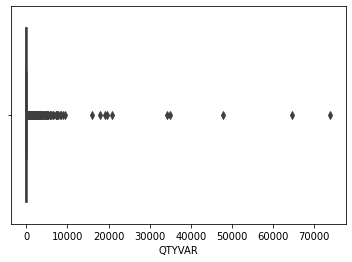

In [56]:
sns.boxplot(x=df['QTYVAR'])

In [57]:
df[df['QTYVAR']>10000]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty
1388,2018-04-23,SKU7186,14O7,159.0,14,O,7,LOC4,IG45,HTS16,1,0,B,PC,CAT17,4.912834e+03,1.0,15900.00,0.800,6.5,4.0,7.0,0.00,0.143314
2449,2018-07-23,SKU1916,16O4,208.0,16,O,4,LOC4,IG49,HTS119,1,1,C,PC,CAT16,4.778136e+03,1.0,20800.00,1.130,30.0,1.5,1.5,0.00,0.181856
3271,2018-09-19,SKU6513,02K1,1719.0,2,K,1,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,3.372806e+03,9.0,19100.00,0.060,148.0,3.0,11.0,0.16,1.370359
4142,2018-10-29,SKU10933,20D2,647.0,20,D,2,LOC4,IG48,HTS24,1,0,B,TB,CAT17,1.374824e+06,1.0,64700.00,5.000,192.0,1.0,2.0,0.00,0.527159
5215,2019-01-16,SKU6481,02P1,3327.0,2,P,1,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,8.974852e+03,17.0,19570.59,0.100,148.0,3.0,11.0,0.02,2.635158
5228,2019-01-16,SKU6580,02P1,1746.0,2,P,1,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,9.931164e+03,5.0,34920.00,0.070,148.0,3.0,7.0,0.19,1.391596
5232,2019-01-16,SKU6621,02K3,1479.0,2,K,3,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,4.704755e+03,2.0,73950.00,0.020,148.0,3.0,7.0,0.01,1.181583
5562,2019-01-29,SKU4707,04D1,343.0,4,D,1,LOC4,IG30,HTS46,1,1,A,YD,CAT12,8.827518e+03,1.0,34300.00,2.336,112.0,8.5,8.5,0.16,0.288043
9155,2019-12-23,SKU7427,4.10E+14,179.0,41,E,13,LOC5,IG26,HTS56,1,1,A,BX,CAT7,2.468232e+04,1.0,17900.00,4.000,13.0,3.0,12.0,0.32,0.159046
10583,2020-12-13,SKU10605,23F1,479.0,23,F,1,LOC4,IG55,HTS95,1,1,C,FT,CAT16,1.151114e+03,1.0,47900.00,70.000,194.0,4.0,4.0,0.00,0.395016


In [58]:
z = np.abs(stats.zscore(df.QTYVAR))
#z = stats.zscore(df.QTYVAR)
df['ZqtyVar']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.05165432 0.02523624 0.00133281 ... 0.08123923 0.14475344 0.09694656]


In [59]:
df.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar
2183,2018-06-27,SKU8088,17K6,-10.0,17,K,6,LOC4,IG45,HTS24,1,1,B,PC,CAT17,-86.9462,1210.0,-0.83,0.43,8.50,5.5,1.00,0.01,0.010385,0.049933
4918,2018-12-05,SKU10678,02F8,-154.0,2,F,8,LOC4,IG35,HTS51,1,1,A,YD,CAT12,-9294.4991,154.0,-100.00,2.88,119.00,8.0,8.00,0.01,0.102881,0.144753
16526,2020-12-13,SKU8866,09Y1,-1.0,9,Y,1,LOC4,IG34,HTS15,1,1,C,BG,CAT12,-10.7588,174.0,-0.57,2.00,3.00,3.0,2.00,0.00,0.017464,0.049685
11317,2020-12-13,SKU11485,1.60E+02,1.0,16,E,1,LOC4,IG58,HTS119,1,1,B,PC,CAT16,2244.2732,0.0,100.00,23.60,39.25,6.0,12.25,0.00,0.019037,0.046474
10483,2020-12-13,SKU10356,14X4,-3.0,14,X,4,LOC4,IG57,HTS15,1,1,C,BX,CAT17,-62.9396,3.0,-100.00,1.00,5.00,5.0,5.00,0.00,0.015891,0.144753


In [60]:
df['QTYVAR'].describe()

count    16326.000000
mean        51.393948
std       1045.906680
min       -100.000000
25%        -50.045000
50%         -1.190000
75%         48.120000
max      73950.000000
Name: QTYVAR, dtype: float64

In [61]:
df['ZqtyVar'].describe()

count    16326.000000
mean         0.122589
std          0.992488
min          0.000042
25%          0.046474
50%          0.053127
75%          0.142088
max         70.657230
Name: ZqtyVar, dtype: float64

In [62]:
print('Dentro de 1 desviación estándar:', df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count(), round(df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['ZqtyVar'] >= 1) & (df['ZqtyVar'] < 2),'ZqtyVar'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['ZqtyVar'] >= 2) & (df['ZqtyVar'] < 3),'ZqtyVar'].count())
print('Más de de 3 desviación estándar:', df.loc[df['ZqtyVar'] > 3,'ZqtyVar'].count())
print('Más de de 4 desviación estándar:', df.loc[df['ZqtyVar'] > 4,'ZqtyVar'].count())
print('Más de de 10 desviación estándar:', df.loc[df['ZqtyVar'] > 10,'ZqtyVar'].count())
print(df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count() + df.loc[(df['ZqtyVar'] >= 1) & (df['ZqtyVar'] < 2),'ZqtyVar'].count() + df.loc[(df['ZqtyVar'] >= 2) & (df['ZqtyVar'] < 3),'ZqtyVar'].count() + df.loc[df['ZqtyVar'] > 3,'ZqtyVar'].count())

Dentro de 1 desviación estándar: 16192 99.18 %
Entre 1 y 2 desviaciones estándar: 57
Entre 2 y 3 desviaciones estándar: 26
Más de de 3 desviación estándar: 51
Más de de 4 desviación estándar: 38
Más de de 10 desviación estándar: 10
16326


In [63]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

QTY            10.000000
COSTX        1354.217825
QTYBEFORE     112.000000
QTYVAR         98.165000
PESO            9.537500
LARGO          96.000000
ALTO            5.750000
ANCHO           5.500000
CONTRPERC       0.030000
Zqty            0.010225
ZqtyVar         0.095614
dtype: float64


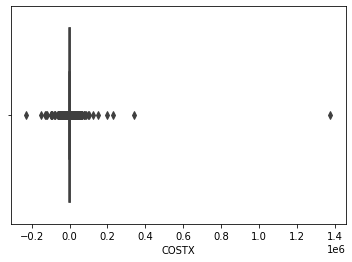

In [64]:
sns.boxplot(x=df['COSTX'])

In [65]:
z = np.abs(stats.zscore(df.COSTX))
#z = stats.zscore(df.COSTX)
df['ZcostX']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.01682033 0.02666085 0.08832645 ... 0.37711288 0.09431554 0.01421791]


In [66]:
df['ZcostX'].describe()

count    1.632600e+04
mean     1.910734e-01
std      9.816058e-01
min      2.280264e-07
25%      1.489870e-02
50%      5.102024e-02
75%      1.454509e-01
max      1.031730e+02
Name: ZcostX, dtype: float64

In [67]:
temp = df.loc[:,['COSTX','ZcostX']]

In [68]:
temp.describe()

,COSTX,ZcostX
count,1.632600e+04,1.632600e+04
mean,-6.573144e+01,1.910734e-01
std,1.332647e+04,9.816058e-01
min,-2.298156e+05,2.280264e-07
25%,-7.366095e+02,1.489870e-02
50%,-3.314560e+01,5.102024e-02
75%,6.176083e+02,1.454509e-01
max,1.374824e+06,1.031730e+02


In [69]:
print('z-score')
print('Dentro de 1 desviación estándar:', df.loc[df['ZcostX'] < 1,'ZcostX'].count(), round(df.loc[df['ZcostX'] < 1,'ZcostX'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['ZcostX'] >= 1) & (df['ZcostX'] < 2),'ZcostX'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['ZcostX'] >= 2) & (df['ZcostX'] <= 3),'ZcostX'].count())
print('Más de de 3 desviación estándar:', df.loc[df['ZcostX'] > 3,'ZcostX'].count())
print('Más de de 4 desviación estándar:', df.loc[df['ZcostX'] > 4,'ZcostX'].count())
print('Más de de 10 desviación estándar:', df.loc[df['ZcostX'] > 10,'ZcostX'].count())
print(df.loc[df['ZcostX'] < 1,'ZcostX'].count() + df.loc[(df['ZcostX'] >= 1) & (df['ZcostX'] < 2),'ZcostX'].count() + df.loc[(df['ZcostX'] >= 2) & (df['ZcostX'] < 3),'ZcostX'].count() + df.loc[df['ZcostX'] > 3,'ZcostX'].count())

z-score
Dentro de 1 desviación estándar: 15719 96.28 %
Entre 1 y 2 desviaciones estándar: 411
Entre 2 y 3 desviaciones estándar: 109
Más de de 3 desviación estándar: 87
Más de de 4 desviación estándar: 51
Más de de 10 desviación estándar: 7
16326


In [70]:
# from google.colab import drive
# drive.mount('/content/drive')
# drivepath = '/content/drive/MyDrive/Colab Notebooks/data'
# df_imp.to_csv('{}/dataframe_imputado.csv'.format(drivepath),index=False)

In [71]:
# Intentemos eliminando aquellos valores de COSTX a más de tres desviaciones estándar de la media
dfTest1=df[df['ZcostX']<=3]

In [72]:
dfTest1.shape

(16239, 26)

In [73]:
temp = dfTest1.loc[:,['COSTX','QTYVAR']]

In [74]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16239 entries, 0 to 17006
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COSTX   16239 non-null  float64
 1   QTYVAR  16239 non-null  float64
dtypes: float64(2)
memory usage: 380.6 KB


In [75]:
z = np.abs(stats.zscore(temp.COSTX))
#z = stats.zscore(df.COSTX)
temp['ZcostX']=z

In [76]:
temp = temp.loc[:,['COSTX','ZcostX']]

In [77]:
temp.describe()

,COSTX,ZcostX
count,16239.000000,16239.000000
mean,-148.030008,0.443962
std,4732.204184,0.896073
min,-40013.935000,0.000011
25%,-727.162600,0.047239
50%,-33.051600,0.140094
75%,614.167300,0.407184
max,39709.661400,8.424643


In [78]:
temp = df.loc[:,['COSTX','ZcostX']]

In [79]:
temp.describe()

,COSTX,ZcostX
count,1.632600e+04,1.632600e+04
mean,-6.573144e+01,1.910734e-01
std,1.332647e+04,9.816058e-01
min,-2.298156e+05,2.280264e-07
25%,-7.366095e+02,1.489870e-02
50%,-3.314560e+01,5.102024e-02
75%,6.176083e+02,1.454509e-01
max,1.374824e+06,1.031730e+02


In [80]:
dfTest1.describe()

,QTY,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
count,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,1.623900e+04
mean,-22.990779,-148.030008,538.217148,46.006304,13.531499,53.902718,4.820439,5.698572,0.085747,0.088864,0.117337,1.569877e-01
std,869.755125,4732.204184,4482.232482,913.386854,42.944162,64.881932,4.617899,4.323142,0.408341,0.678324,0.865420,3.185811e-01
min,-47000.000000,-40013.935000,0.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000159,0.000042,2.280264e-07
25%,-6.000000,-727.162600,2.000000,-50.000000,0.460000,6.000000,1.500000,2.500000,0.000000,0.016677,0.046474,1.478133e-02
50%,-1.000000,-33.051600,18.000000,-1.180000,2.020000,12.000000,3.500000,5.500000,0.010000,0.019037,0.052964,5.025968e-02
75%,4.000000,614.167300,113.000000,46.935000,9.800000,102.000000,7.250000,8.000000,0.030000,0.026116,0.142088,1.434093e-01
max,16624.000000,39709.661400,322475.000000,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000,36.950396,70.657230,2.997751e+00


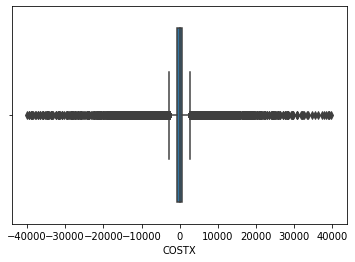

In [81]:
sns.boxplot(x=dfTest1['COSTX'])

In [82]:
# Borramos las columnas irrelevantes
dfTest1 = dfTest1.drop(['ZcostX'], axis=1)
z = np.abs(stats.zscore(dfTest1.COSTX))
#z = stats.zscore(dfTest1.COSTX)
dfTest1['ZcostX']=z

In [83]:
dfTest1['ZcostX'].describe()

count    16239.000000
mean         0.443962
std          0.896073
min          0.000011
25%          0.047239
50%          0.140094
75%          0.407184
max          8.424643
Name: ZcostX, dtype: float64

In [84]:
print('Dentro de 1 desviación estándar:', dfTest1.loc[dfTest1['ZcostX'] < 1,'ZcostX'].count(), round(dfTest1.loc[dfTest1['ZcostX'] < 1,'ZcostX'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', dfTest1.loc[(dfTest1['ZcostX'] >= 1) & (dfTest1['ZcostX'] < 2),'ZcostX'].count())
print('Entre 2 y 3 desviaciones estándar:', dfTest1.loc[(dfTest1['ZcostX'] >= 2) & (dfTest1['ZcostX'] <= 3),'ZcostX'].count())
print('Más de de 3 desviación estándar:', dfTest1.loc[dfTest1['ZcostX'] > 3,'ZcostX'].count())
print('Más de de 4 desviación estándar:', dfTest1.loc[dfTest1['ZcostX'] > 4,'ZcostX'].count())
print('Más de de 5 desviación estándar:', dfTest1.loc[dfTest1['ZcostX'] > 5,'ZcostX'].count())
print('Más de de 10 desviación estándar:', dfTest1.loc[dfTest1['ZcostX'] > 10,'ZcostX'].count())
print(dfTest1.loc[dfTest1['ZcostX'] < 1,'ZcostX'].count() + dfTest1.loc[(dfTest1['ZcostX'] >= 1) & (dfTest1['ZcostX'] < 2),'ZcostX'].count() + dfTest1.loc[(dfTest1['ZcostX'] >= 2) & (dfTest1['ZcostX'] < 3),'ZcostX'].count() + dfTest1.loc[dfTest1['ZcostX'] > 3,'ZcostX'].count())

Dentro de 1 desviación estándar: 14535 89.03 %
Entre 1 y 2 desviaciones estándar: 891
Entre 2 y 3 desviaciones estándar: 348
Más de de 3 desviación estándar: 465
Más de de 4 desviación estándar: 255
Más de de 5 desviación estándar: 158
Más de de 10 desviación estándar: 0
16239


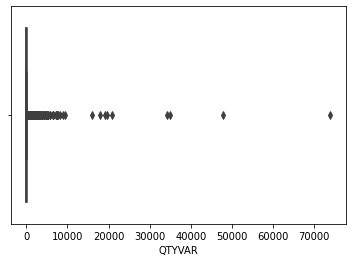

In [85]:
sns.boxplot(x=dfTest1['QTYVAR'])

In [86]:
temp= dfTest1[dfTest1['QTYVAR']<1000]

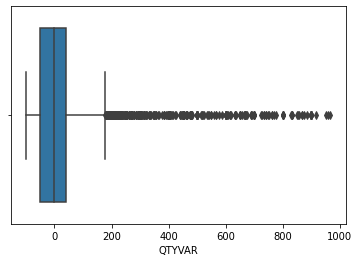

In [87]:
sns.boxplot(x=temp['QTYVAR'])

In [88]:
#dfTest1.to_csv('{}/dataframe_imputado_test1.csv'.format(drivepath),index=False)

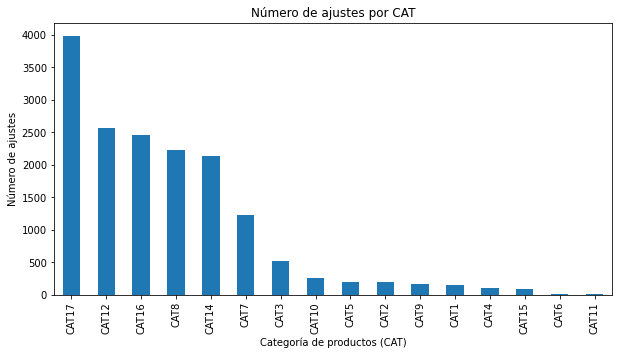

In [89]:
# Plotting a Histogram
dfTest1.CAT.value_counts().plot(kind='bar', figsize=(10,5))
# nlargest(40).
plt.title('Número de ajustes por CAT')
plt.ylabel('Número de ajustes')
plt.xlabel('Categoría de productos (CAT)');

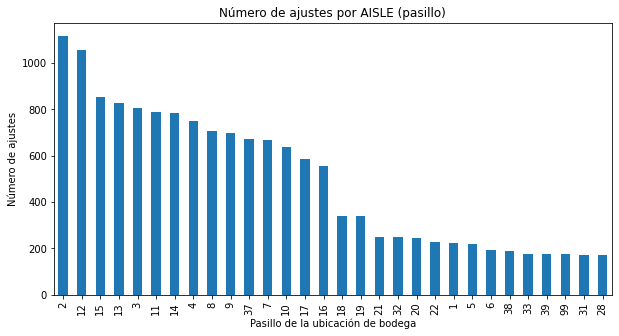

In [90]:
# Plotting a Histogram
dfTest1.AISLE.value_counts().nlargest(30).plot(kind='bar', figsize=(10,5))
# nlargest(40).
plt.title('Número de ajustes por AISLE (pasillo)')
plt.ylabel('Número de ajustes')
plt.xlabel('Pasillo de la ubicación de bodega');

In [91]:
dfTest1.AISLE.value_counts().nlargest(30)

2     1117
12    1056
15     851
13     826
3      805
11     786
14     785
4      751
8      704
9      699
37     671
7      665
10     636
17     586
16     554
18     339
19     339
21     250
32     250
20     246
22     226
1      221
5      219
6      193
38     186
33     177
39     176
99     175
31     169
28     169
Name: AISLE, dtype: int64

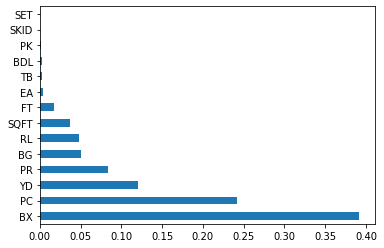

In [92]:
dfTest1.UOM.value_counts(normalize=True).plot.barh()
plt.show()

In [93]:
dfTest1['AISLE'].unique()

array(['17', '15', '18', '19', '22', '2', '23', '16', '13', '12', '14',
       '99', '3', '0', '24', '20', '26', '21', '25', '11', '27', '28',
       '34', '4', '6', '5', '9', '29', '35', '32', '33', '37', '8', '7',
       '30', '31', '10', '1', '40', '38', '39', '41', '88'], dtype=object)

In [94]:
dfTest1.describe(include="object")

,SKU,LOC,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT
count,16239,16239,16239,16239,16239,16239,16239,16239,16239,16239,16239,16239,16239
unique,5288,4350,43,34,24,4,65,133,2,2,3,14,16
top,SKU1796,99D11,2,D,2,LOC4,IG45,HTS119,1,1,A,BX,CAT17
freq,106,38,1117,892,3495,15574,1572,3763,15017,13428,7073,6351,3986


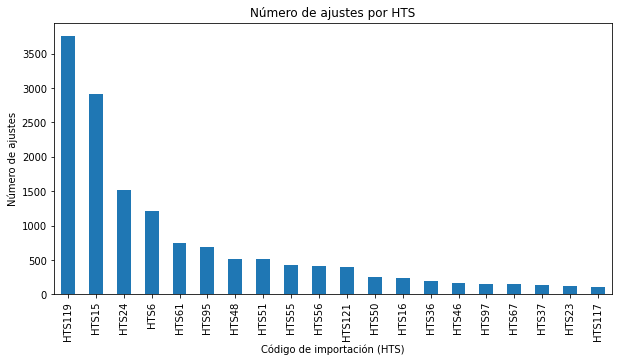

In [95]:
# Plotting a Histogram
dfTest1.HTS.value_counts().nlargest(20).plot(kind='bar', figsize=(10,5))
plt.title('Número de ajustes por HTS')
plt.ylabel('Número de ajustes')
plt.xlabel('Código de importación (HTS)');

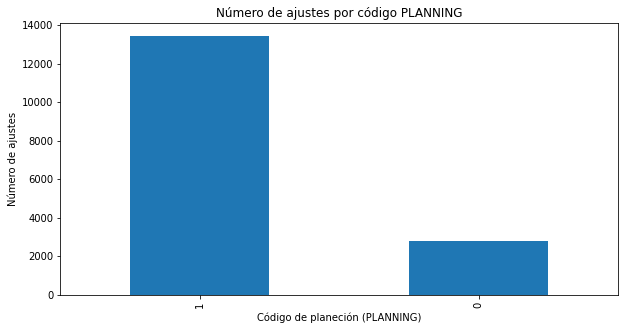

In [96]:
# Plotting a Histogram
dfTest1.PLANNING.value_counts().plot(kind='bar', figsize=(10,5))
plt.title('Número de ajustes por código PLANNING')
plt.ylabel('Número de ajustes')
plt.xlabel('Código de planeción (PLANNING)');

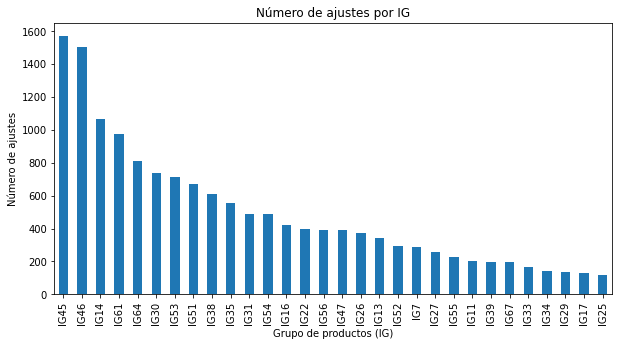

In [97]:
# Plotting a Histogram
dfTest1.IG.value_counts().nlargest(30).plot(kind='bar', figsize=(10,5))
plt.title('Número de ajustes por IG')
plt.ylabel('Número de ajustes')
plt.xlabel('Grupo de productos (IG)');

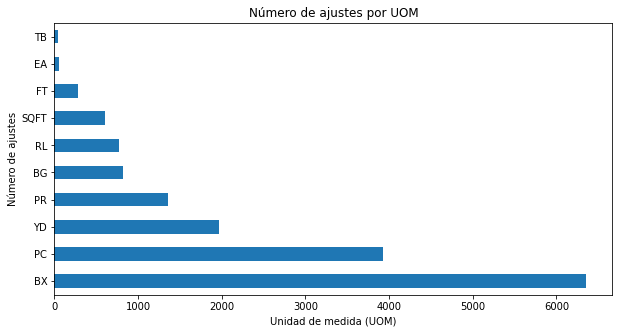

In [98]:
# Plotting a Histogram
dfTest1.UOM.value_counts().nlargest(10).plot(kind='barh', figsize=(10,5))
#nlargest(30).
plt.title('Número de ajustes por UOM')
plt.ylabel('Número de ajustes')
plt.xlabel('Unidad de medida (UOM)');

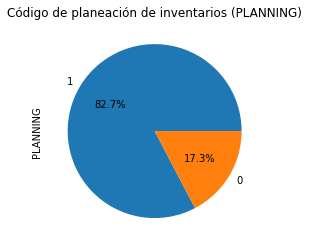

In [99]:
dfTest1.PLANNING.value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.title('Código de planeación de inventarios (PLANNING)')
plt.show()

A    43.56
C    35.16
B    21.28
Name: ABC, dtype: float64 %


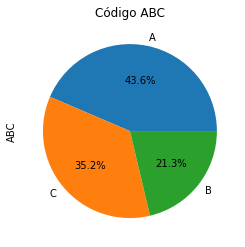

In [100]:
print(round(dfTest1.ABC.value_counts(normalize=True).nlargest(15)*100,2),'%')
dfTest1.ABC.value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.title('Código ABC')
plt.show()

HTS119    23.17
HTS15     17.97
HTS24      9.38
HTS6       7.51
HTS61      4.63
HTS95      4.26
HTS48      3.17
HTS51      3.15
HTS55      2.65
HTS56      2.59
HTS121     2.48
HTS50      1.58
HTS16      1.47
HTS36      1.21
HTS46      0.99
Name: HTS, dtype: float64 %


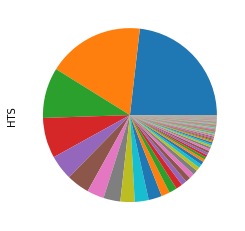

In [101]:
print(round(dfTest1.HTS.value_counts(normalize=True).nlargest(15)*100,2),'%')
dfTest1.HTS.value_counts(normalize=True).plot.pie(labels=None)
plt.show()

In [102]:
dfTest1.describe(include="object")

,SKU,LOC,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT
count,16239,16239,16239,16239,16239,16239,16239,16239,16239,16239,16239,16239,16239
unique,5288,4350,43,34,24,4,65,133,2,2,3,14,16
top,SKU1796,99D11,2,D,2,LOC4,IG45,HTS119,1,1,A,BX,CAT17
freq,106,38,1117,892,3495,15574,1572,3763,15017,13428,7073,6351,3986


,QTY,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
QTY,1.000000,0.140475,-0.331435,0.043265,0.007970,0.017979,0.022922,0.027125,0.004448,-0.691366,0.030288,-0.042688
COSTX,0.140475,1.000000,-0.020314,0.105971,-0.007328,-0.008176,-0.012876,-0.009912,-0.030780,-0.041602,0.051211,-0.128044
QTYBEFORE,-0.331435,-0.020314,1.000000,-0.006834,-0.033331,-0.053712,-0.083066,-0.087289,-0.016263,0.461872,-0.008221,-0.004390
QTYVAR,0.043265,0.105971,-0.006834,1.000000,-0.002623,0.023713,-0.003407,0.006051,0.006746,0.027518,0.992716,0.054731
PESO,0.007970,-0.007328,-0.033331,-0.002623,1.000000,0.297762,0.204676,0.169340,0.182254,-0.026584,-0.004228,0.175322
LARGO,0.017979,-0.008176,-0.053712,0.023713,0.297762,1.000000,0.105873,0.184510,0.205037,-0.036356,0.027871,0.183758
ALTO,0.022922,-0.012876,-0.083066,-0.003407,0.204676,0.105873,1.000000,0.715588,0.163442,-0.074904,-0.000838,0.200647
ANCHO,0.027125,-0.009912,-0.087289,0.006051,0.169340,0.184510,0.715588,1.000000,0.098289,-0.070788,0.007963,0.153587
CONTRPERC,0.004448,-0.030780,-0.016263,0.006746,0.182254,0.205037,0.163442,0.098289,1.000000,-0.015456,0.005529,0.373896
Zqty,-0.691366,-0.041602,0.461872,0.027518,-0.026584,-0.036356,-0.074904,-0.070788,-0.015456,1.000000,0.029859,0.096721


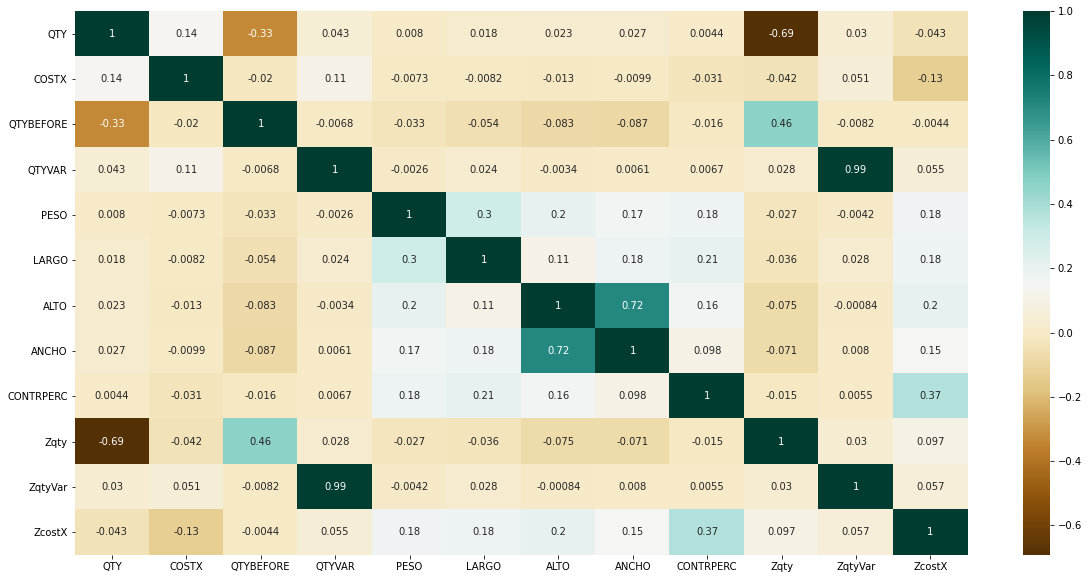

In [103]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= dfTest1.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

In [104]:
# Llamativo ALTO-ANCHO, tal vez la forma de las cajas?

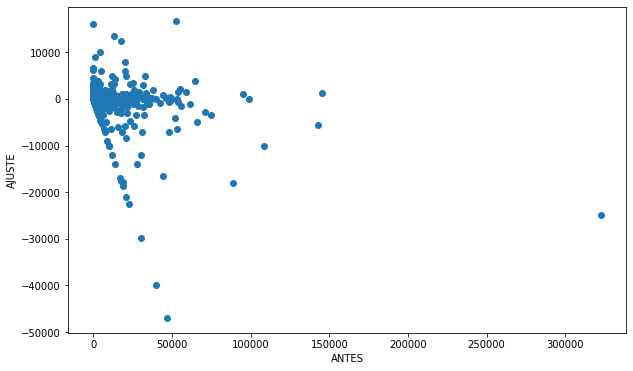

In [105]:
# Plotting a scatter plot
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(dfTest1['QTYBEFORE'], dfTest1['QTY'])
ax.set_xlabel('ANTES')
ax.set_ylabel('AJUSTE')
plt.show()

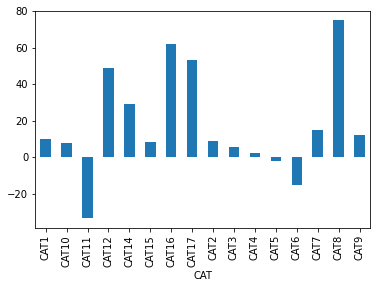

In [106]:
dfTest1.groupby('CAT')['QTYVAR'].mean().plot.bar()
#print(result)
plt.show()

In [107]:
dfTest1.describe()

,QTY,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
count,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000,16239.000000
mean,-22.990779,-148.030008,538.217148,46.006304,13.531499,53.902718,4.820439,5.698572,0.085747,0.088864,0.117337,0.443962
std,869.755125,4732.204184,4482.232482,913.386854,42.944162,64.881932,4.617899,4.323142,0.408341,0.678324,0.865420,0.896073
min,-47000.000000,-40013.935000,0.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000159,0.000042,0.000011
25%,-6.000000,-727.162600,2.000000,-50.000000,0.460000,6.000000,1.500000,2.500000,0.000000,0.016677,0.046474,0.047239
50%,-1.000000,-33.051600,18.000000,-1.180000,2.020000,12.000000,3.500000,5.500000,0.010000,0.019037,0.052964,0.140094
75%,4.000000,614.167300,113.000000,46.935000,9.800000,102.000000,7.250000,8.000000,0.030000,0.026116,0.142088,0.407184
max,16624.000000,39709.661400,322475.000000,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000,36.950396,70.657230,8.424643


In [108]:
dfTest1.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,...,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
4298,2018-11-02,SKU11228,09M2,-1.0,9,M,2,LOC4,IG43,HTS170,2,0,...,CAT10,-5.3778,41.0,-2.44,0.4375,7.0,1.0,4.0,0.00,0.017464,0.051473,0.030146
3300,2018-09-20,SKU2164,11M1,6.0,11,M,1,LOC4,IG53,HTS119,1,1,...,CAT16,262.8495,158.0,3.80,1.8300,49.0,1.0,4.0,0.00,0.022970,0.045506,0.086829
618,2018-03-05,SKU7851,15U4,-18.0,15,U,4,LOC4,IG45,HTS24,1,1,...,CAT17,-236.6223,407.0,-4.42,0.4000,7.5,1.0,5.0,0.01,0.004092,0.053366,0.018722
16969,2020-12-13,SKU6167,21B6,-1.0,21,B,6,LOC4,IG7,HTS95,1,1,...,CAT8,-1055.3701,5.0,-20.00,60.0000,192.0,3.0,7.0,0.00,0.017464,0.068262,0.191743
16812,2019-01-14,SKU7325,01U2,-3.0,1,U,2,LOC4,IG2,HTS97,2,0,...,CAT1,-1647.5983,20.0,-15.00,47.0000,14.0,2.0,14.0,0.00,0.015891,0.063482,0.316896


In [109]:
dfTest1.query('LARGO > ALTO')

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,...,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
28,2018-02-10,SKU3992,12I6,-144.0,12,I,6,LOC4,IG46,HTS119,1,1,...,CAT17,-8177.0401,144.0,-100.00,1.7,36.5,3.250,3.00,0.01,0.095015,0.144753,1.696727
29,2018-02-10,SKU3992,1.70E+06,-4.0,17,E,5,LOC4,IG46,HTS119,1,1,...,CAT17,-227.1400,102.0,-3.92,1.7,36.5,3.250,3.00,0.01,0.015104,0.052888,0.016718
30,2018-02-10,SKU3992,17V1,3.0,17,V,1,LOC4,IG46,HTS119,1,1,...,CAT17,170.3550,158.0,1.90,1.7,36.5,3.250,3.00,0.01,0.020610,0.047323,0.067283
31,2018-02-10,SKU3993,13L6,-6.0,13,L,6,LOC4,IG46,HTS119,1,1,...,CAT17,-340.7100,97.0,-6.19,1.7,36.5,3.250,3.00,0.04,0.013531,0.055058,0.040718
32,2018-02-10,SKU3993,13T1,-52.0,13,T,1,LOC4,IG46,HTS119,1,1,...,CAT17,-2952.8200,53.0,-98.11,1.7,36.5,3.250,3.00,0.04,0.022651,0.142946,0.592721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,2020-12-13,SKU8964,23C10,1.0,23,C,10,LOC5,IG5,HTS67,1,0,...,CAT2,316.3834,0.0,100.00,45.0,162.0,2.375,6.00,0.00,0.019037,0.046474,0.098142
17003,2020-12-13,SKU8971,21I2,2.0,21,I,2,LOC4,IG5,HTS67,1,0,...,CAT2,626.9100,0.0,100.00,45.0,162.0,2.375,6.00,0.00,0.019823,0.046474,0.163764
17004,2020-12-13,SKU8972,22F8,15.0,22,F,8,LOC4,IG5,HTS67,1,0,...,CAT2,4959.6974,11.0,136.36,45.0,162.0,2.375,6.00,0.00,0.030049,0.081239,1.079388
17005,2020-12-13,SKU8972,24I4,-4.0,24,I,4,LOC4,IG5,HTS67,1,0,...,CAT2,-1322.5860,4.0,-100.00,45.0,162.0,2.375,6.00,0.00,0.015104,0.144753,0.248212


In [110]:
print("Peso  (0):",dfTest1.loc[dfTest1['PESO']==0].shape[0]);
print("Largo (0):",dfTest1.loc[dfTest1['LARGO']==0].shape[0]);
print("Ancho (0):",dfTest1.loc[dfTest1['ANCHO']==0].shape[0]);
print("Alto  (0):",dfTest1.loc[dfTest1['ALTO']==0].shape[0]);

Peso  (0): 1004
Largo (0): 1282
Ancho (0): 1282
Alto  (0): 1282


In [111]:
# Descartar dimensiones

In [112]:
dfTest1.dtypes

TDATE        datetime64[ns]
SKU                  object
LOC                  object
QTY                 float64
AISLE                object
COLUMN               object
SHELF                object
TYPE                 object
IG                   object
HTS                  object
CLASS                object
PLANNING             object
ABC                  object
UOM                  object
CAT                  object
COSTX               float64
QTYBEFORE           float64
QTYVAR              float64
PESO                float64
LARGO               float64
ALTO                float64
ANCHO               float64
CONTRPERC           float64
Zqty                float64
ZqtyVar             float64
ZcostX              float64
dtype: object

In [113]:
# Backup
dfTest2 = dfTest1
# dfTest2.to_csv('{}/dataframe_imputado_test2.csv'.format(drivepath),index=False)

In [114]:
# Borramos las columnas que no serán utilizados en este primer intento
dfTest1 = dfTest1.drop(['TDATE','SKU','LOC','COLUMN','SHELF','TYPE','QTYBEFORE','PESO','LARGO','ALTO','ANCHO','Zqty','ZqtyVar','ZcostX','QTY','CONTRPERC'], axis=1)

In [115]:
dfTest1['PLANNING'] =dfTest1['CLASS'] + "/" + dfTest1['PLANNING']

In [116]:
dfTest1 = dfTest1.drop(['CLASS'], axis=1)

In [117]:
dfTest1['PLANNING'].value_counts()

1/1    13428
1/0     1589
2/0     1222
Name: PLANNING, dtype: int64

In [118]:
dfTest1.dtypes

AISLE        object
IG           object
HTS          object
PLANNING     object
ABC          object
UOM          object
CAT          object
COSTX       float64
QTYVAR      float64
dtype: object

In [120]:
contingency = pd.crosstab(dfTest1['ABC'], dfTest1['PLANNING']) 
contingency 

PLANNING,1/0,1/1,2/0
ABC,,,
A,202,6789,82
B,209,3053,194
C,1178,3586,946


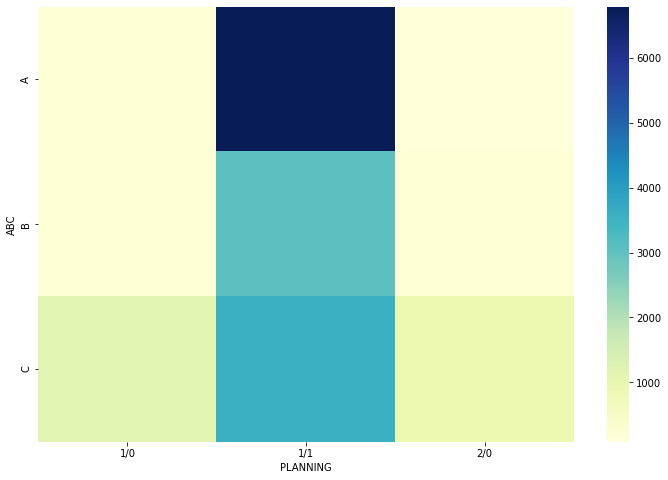

In [121]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contingency, annot=False, cmap="YlGnBu")

,COSTX,QTYVAR
COSTX,1.000000,0.105971
QTYVAR,0.105971,1.000000


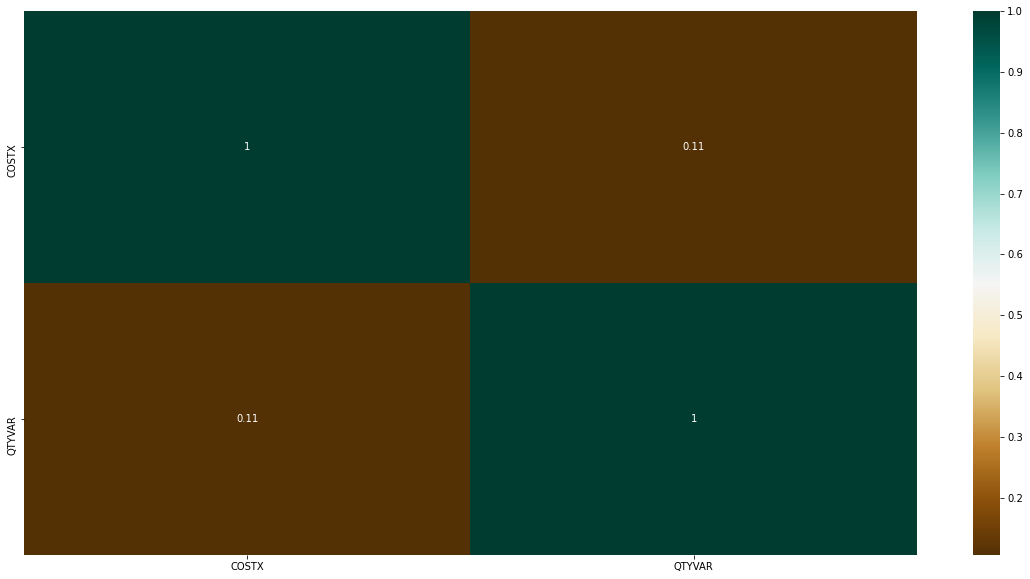

In [122]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= dfTest1.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

In [95]:
dfTest1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16239 entries, 0 to 17006
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AISLE     16239 non-null  object 
 1   IG        16239 non-null  object 
 2   HTS       16239 non-null  object 
 3   PLANNING  16239 non-null  object 
 4   ABC       16239 non-null  object 
 5   UOM       16239 non-null  object 
 6   CAT       16239 non-null  object 
 7   COSTX     16239 non-null  float64
 8   QTYVAR    16239 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.2+ MB


In [107]:
dfTest1.describe()

,COSTX,QTYVAR
count,16239.000000,16239.000000
mean,-148.030008,46.006304
std,4732.204184,913.386854
min,-40013.935000,-100.000000
25%,-727.162600,-50.000000
50%,-33.051600,-1.180000
75%,614.167300,46.935000
max,39709.661400,73950.000000


In [96]:
dfTest1.reset_index(drop=True, inplace=True)

In [97]:
# dfTest1.to_csv('{}/dataframe_imputado_test1.csv'.format(drivepath),index=False)

In [98]:
# Get the position of categorical columns
catColumnsPos = [dfTest1.columns.get_loc(col) for col in list(dfTest1.select_dtypes('object').columns)]
print('Categorical columns : {}'.format(list(dfTest1.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catColumnsPos))

Categorical columns : ['AISLE', 'IG', 'HTS', 'PLANNING', 'ABC', 'UOM', 'CAT']
Categorical columns position : [0, 1, 2, 3, 4, 5, 6]


In [99]:
# Get the position of numerical columns
numColumnsPos = [dfTest1.columns.get_loc(col) for col in list(dfTest1.select_dtypes('float64').columns)]
print('Numerical columns : {}'.format(list(dfTest1.select_dtypes('float64').columns)))
print('Numerical columns position : {}'.format(numColumnsPos))

Numerical columns : ['COSTX', 'QTYVAR']
Numerical columns position : [7, 8]


In [100]:
numdf = dfTest1[list(dfTest1.select_dtypes('float64').columns)]

In [101]:
scaled_features = StandardScaler().fit_transform(numdf.values)
scaled_features_df = pd.DataFrame(scaled_features, index=numdf.index, columns=numdf.columns)
scaled_features_df

,COSTX,QTYVAR
0,-0.029976,-0.053250
1,0.092472,-0.022999
2,0.266130,0.004373
3,-0.025112,-0.060323
4,-0.077982,-0.062534
...,...,...
16234,0.098142,0.059116
16235,0.163764,0.059116
16236,1.079388,0.098925
16237,-0.248212,-0.159856


In [102]:
scaled_features_df.describe()

,COSTX,QTYVAR
count,1.623900e+04,1.623900e+04
mean,-1.419668e-16,1.460120e-16
std,1.000031e+00,1.000031e+00
min,-8.424643e+00,-1.598565e-01
25%,-1.223849e-01,-1.051135e-01
50%,2.429776e-02,-5.166240e-02
75%,1.610710e-01,1.016792e-03
max,8.422908e+00,8.091453e+01


In [103]:
catdf = dfTest1[list(dfTest1.select_dtypes('object').columns)]

In [104]:
print("catdf",catdf.shape)
print("scaled_features_df",scaled_features_df.shape)
print(catdf.head(5))
print(scaled_features_df.head(5))
dfNoSupervisado1 = pd.concat((catdf, scaled_features_df), axis = 1)
dfNoSupervisado1

catdf (16239, 7)
scaled_features_df (16239, 2)
  AISLE    IG     HTS PLANNING ABC UOM    CAT
0    17  IG56  HTS119      1/1   B  PC  CAT17
1    17  IG56  HTS119      1/1   B  PC  CAT17
2    17  IG56  HTS119      1/1   C  PC  CAT17
3    17  IG56  HTS119      1/1   B  PC  CAT17
4    15  IG56  HTS119      1/1   C  PC  CAT17
      COSTX    QTYVAR
0 -0.029976 -0.053250
1  0.092472 -0.022999
2  0.266130  0.004373
3 -0.025112 -0.060323
4 -0.077982 -0.062534


,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR
0,17,IG56,HTS119,1/1,B,PC,CAT17,-0.029976,-0.053250
1,17,IG56,HTS119,1/1,B,PC,CAT17,0.092472,-0.022999
2,17,IG56,HTS119,1/1,C,PC,CAT17,0.266130,0.004373
3,17,IG56,HTS119,1/1,B,PC,CAT17,-0.025112,-0.060323
4,15,IG56,HTS119,1/1,C,PC,CAT17,-0.077982,-0.062534
...,...,...,...,...,...,...,...,...,...
16234,23,IG5,HTS67,1/0,C,BX,CAT2,0.098142,0.059116
16235,21,IG5,HTS67,1/0,C,BX,CAT2,0.163764,0.059116
16236,22,IG5,HTS67,1/0,C,BX,CAT2,1.079388,0.098925
16237,24,IG5,HTS67,1/0,C,BX,CAT2,-0.248212,-0.159856


In [105]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [ ]:
dfNoSupervisado1.to_csv("/content/gdrive/MyDrive/TDGdata/dfstd050621.csv", index = False)

In [ ]:
dfTest1.to_csv("/content/gdrive/MyDrive/TDGdata/dfNostd050621.csv", index = False)